In [1]:
# Importing our Utilities functions:
from utils import CautDataloaderRegular
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# Modelling
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# 64, 32
# 32, 16
def LSTM_grid_search_Audio(csv_path,
                           data_dir,
                           feature_type=None,
                           lstm_feat_size_lst=[16, 32, 64, 128, 256],
                           inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                           epoch_num=100,
                           batch_size=32,
                           verbose=False):
    for lstm_feat_size_tmp in lstm_feat_size_lst:
        for inner_dense_size_tmp in inner_dense_layer_size_lst:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            print(f"LSTM Layer Size       : {lstm_feat_size_tmp}")
            print(f"Inner Dense Layer Size: {inner_dense_size_tmp}")
            print(f"Epoch Num             : {epoch_num}")
            LSTM_Model_Audio(csv_path=csv_path,
                             data_dir=data_dir,
                             lstm_features_size=lstm_feat_size_tmp,
                             inner_dense_size=inner_dense_size_tmp,
                             epochs_num=epoch_num,
                             feature_type=feature_type,
                             batch_size=batch_size,
                             threshold=0.5,
                             train_verbose=False)
            print("\n\n")
            print("##########################################")
            
        
# # Do grid search:
# LSTM_grid_search_Audio(lstm_feat_size_lst=[16, 32, 64, 128, 256],
#                        inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
#                        epoch_num=100,
#                        batch_size=32,
#                        verbose=False)



def LSTM_Model_Audio(csv_path,
                     data_dir,
                     lstm_features_size,
                     inner_dense_size,
                     epochs_num,
                     feature_type="MFCC",
                     batch_size=32,
                     threshold=0.5,
                     train_verbose=True):

    X_y_data = CautDataloaderRegular.get_X_y_TrainTest_Audio(csv_path=csv_path,
                                                             data_dir=data_dir,
                                                             feature_type=feature_type,
                                                             input_length_in_seconds=3,
                                                             class_to_num_dict={"truth": 0, "lie": 1},
                                                             verbose=train_verbose)
    
    X_train, y_train = X_y_data[0], X_y_data[1]
    X_test, y_test = X_y_data[2], X_y_data[3]
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # setup model's input length, feature amount, and expected class num
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    n_outputs = 1
    
    # lstm_features_size, inner_dense_size => default 100
    
    # Setup model:
    model = Sequential()
    model.add(LSTM(lstm_features_size, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(inner_dense_size, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # fit network
    epochs = epochs_num
    batch_size = 32
    train_verbose = train_verbose
    # also, add Early stopping:
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                               patience=15)
    
    model.fit(X_train,
              y_train,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping_callback],
              verbose=train_verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(X_test,
                                 y_test,
                                 batch_size=batch_size,
                                 verbose=0)
    
    # predict on test data:
    y_pred = model.predict(X_test, batch_size=32) 
    y_pred = np.where(y_pred > threshold, 1, 0)
    
    # get metrics (accuracy, precision, recall)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    # log accuracy:
    print("Accuracy:", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    
    # show confusion matrix
    CautDataloaderRegular.plot_confusion_matrix(y_test, y_pred)

# MediaPipe (Sequential only, since LSTM can only do sequences):

data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
Processed 100 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 200 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 300 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 400 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 0
Processed 500 / 520
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 100 / 223
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
Processed 200 / 223
  - Audio sample shape & label:
    - X_data: (130, 20)
    - y_data: 1
----------------------------
Gathered data shapes:
X_train.shape: (520, 130, 20)
y_train.shape: (520,)
X_test.shape: (223, 130, 20)
y_test.shape: (223,)
(520, 130, 20) (520,) (223, 130, 20) (223,)
Epoch 1/100
17/17 [=============

17/17 [==============================] - 1s 51ms/step - loss: 0.1528 - accuracy: 0.9269
Epoch 73/100
17/17 [==============================] - 1s 55ms/step - loss: 0.1246 - accuracy: 0.9423
Epoch 74/100
17/17 [==============================] - 1s 53ms/step - loss: 0.1237 - accuracy: 0.9442
Epoch 75/100
17/17 [==============================] - 1s 54ms/step - loss: 0.1257 - accuracy: 0.9481
Epoch 76/100
17/17 [==============================] - 1s 52ms/step - loss: 0.1283 - accuracy: 0.9404
Epoch 77/100
17/17 [==============================] - 1s 53ms/step - loss: 0.1452 - accuracy: 0.9269
Epoch 78/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1244 - accuracy: 0.9462
Epoch 79/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1334 - accuracy: 0.9404
Epoch 80/100
17/17 [==============================] - 1s 52ms/step - loss: 0.1341 - accuracy: 0.9462
Epoch 81/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0984 - accuracy: 0.9538
Epo

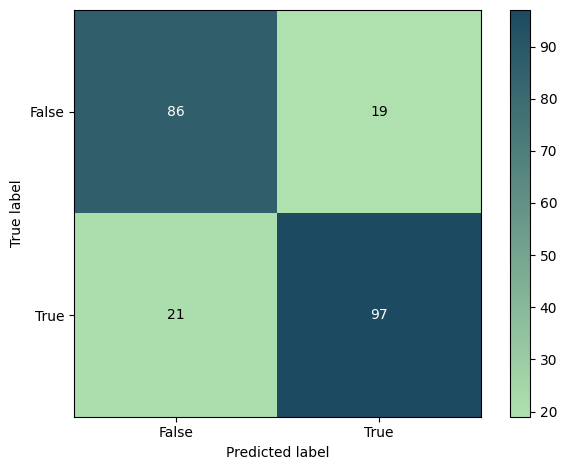

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8362068965517241
     - Negative predictive value:  0.8037383177570093
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.16379310344827586


In [2]:
# based on top performing model from grid search:
# - Accuracy: 0.8834080717488789
# - Precision 0.8709677419354839
# - Recall 0.9152542372881356
LSTM_Model_Audio(csv_path="../../../data/data_split_paths_CSVs/",
                 data_dir="../../../data/audio_features/",
                 lstm_features_size=256,  # 100,
                 inner_dense_size=16,  # 32,
                 epochs_num=100,
                 batch_size=32,
                 feature_type="MFCC",
                 threshold=0.5,
                 train_verbose=True)

# Let's search for good OpenFace parameter:

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 16
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.695067264573991
Precision 0.7083333333333334
Recall 0.7203389830508474


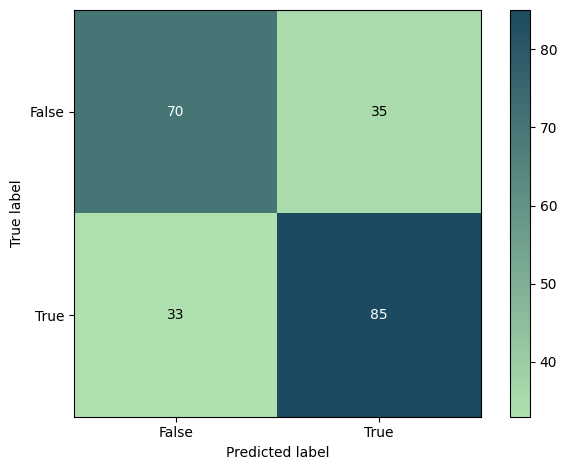

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 85
     - False Positive           : 35
     - True Negative            : 70
     - False Negative           : 33
     - True Positive Rate       :  0.7203389830508474
     - True Negative Rate       :  0.6666666666666666
     - Positive Predictive Value:  0.7083333333333334
     - Negative predictive value:  0.6796116504854369
     - False Positive Rate      :  0.3333333333333333
     - False Negative Rate      :  0.2796610169491525
     - False Discovery Rate     :  0.2916666666666667



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 32
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 7ms/step
A

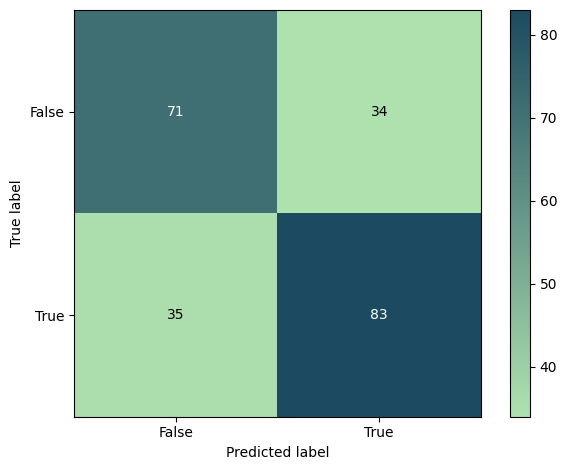

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 83
     - False Positive           : 34
     - True Negative            : 71
     - False Negative           : 35
     - True Positive Rate       :  0.7033898305084746
     - True Negative Rate       :  0.6761904761904762
     - Positive Predictive Value:  0.7094017094017094
     - Negative predictive value:  0.6698113207547169
     - False Positive Rate      :  0.3238095238095238
     - False Negative Rate      :  0.2966101694915254
     - False Discovery Rate     :  0.2905982905982906



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 64
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 6ms/step
A

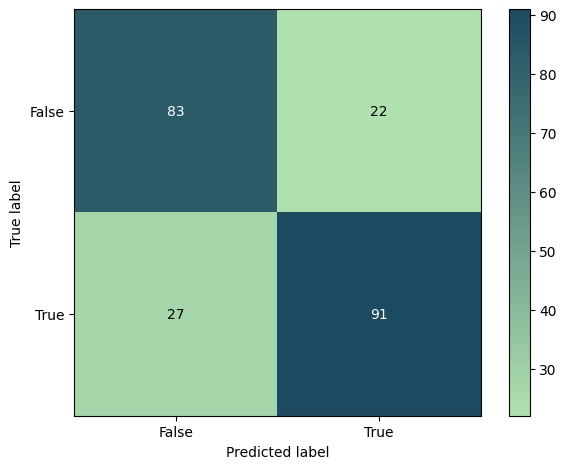

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 91
     - False Positive           : 22
     - True Negative            : 83
     - False Negative           : 27
     - True Positive Rate       :  0.7711864406779662
     - True Negative Rate       :  0.7904761904761904
     - Positive Predictive Value:  0.8053097345132744
     - Negative predictive value:  0.7545454545454545
     - False Positive Rate      :  0.20952380952380953
     - False Negative Rate      :  0.2288135593220339
     - False Discovery Rate     :  0.19469026548672566



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 128
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 7ms/ste

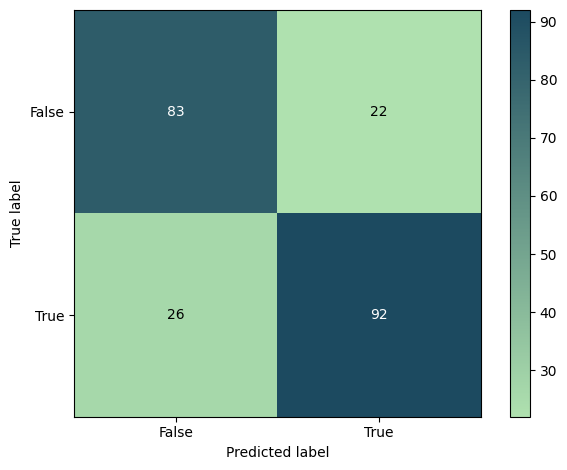

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 92
     - False Positive           : 22
     - True Negative            : 83
     - False Negative           : 26
     - True Positive Rate       :  0.7796610169491526
     - True Negative Rate       :  0.7904761904761904
     - Positive Predictive Value:  0.8070175438596491
     - Negative predictive value:  0.7614678899082569
     - False Positive Rate      :  0.20952380952380953
     - False Negative Rate      :  0.22033898305084745
     - False Discovery Rate     :  0.19298245614035087



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 16
Inner Dense Layer Size: 256
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 7ms/st

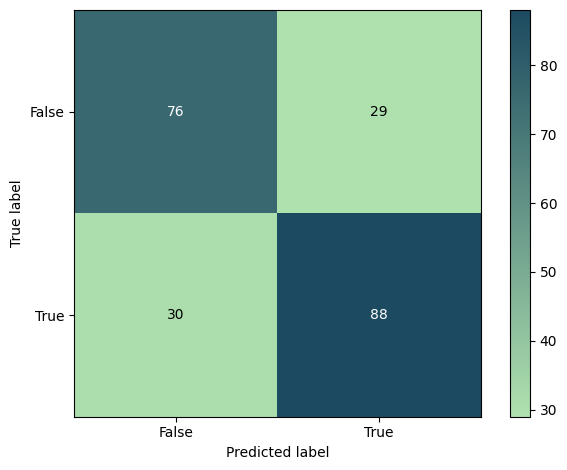

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 88
     - False Positive           : 29
     - True Negative            : 76
     - False Negative           : 30
     - True Positive Rate       :  0.7457627118644068
     - True Negative Rate       :  0.7238095238095238
     - Positive Predictive Value:  0.7521367521367521
     - Negative predictive value:  0.7169811320754716
     - False Positive Rate      :  0.2761904761904762
     - False Negative Rate      :  0.2542372881355932
     - False Discovery Rate     :  0.24786324786324787



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 16
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 12ms/step

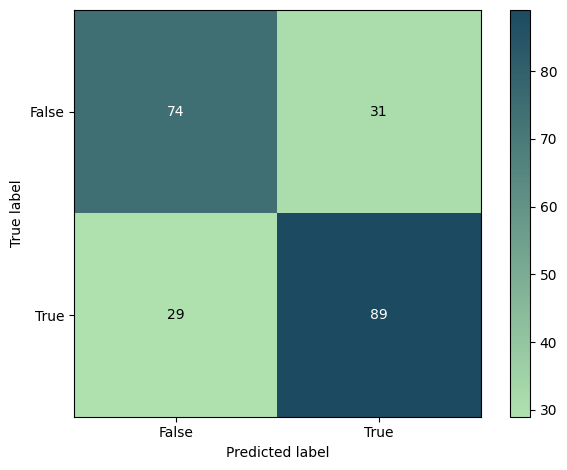

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 89
     - False Positive           : 31
     - True Negative            : 74
     - False Negative           : 29
     - True Positive Rate       :  0.7542372881355932
     - True Negative Rate       :  0.7047619047619048
     - Positive Predictive Value:  0.7416666666666667
     - Negative predictive value:  0.7184466019417476
     - False Positive Rate      :  0.29523809523809524
     - False Negative Rate      :  0.2457627118644068
     - False Discovery Rate     :  0.25833333333333336



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 32
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 9ms/step

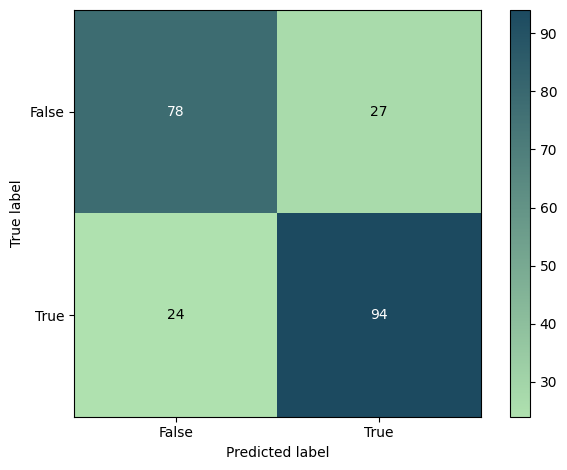

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 27
     - True Negative            : 78
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.7428571428571429
     - Positive Predictive Value:  0.7768595041322314
     - Negative predictive value:  0.7647058823529411
     - False Positive Rate      :  0.2571428571428571
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.2231404958677686



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 64
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 9ms/step
A

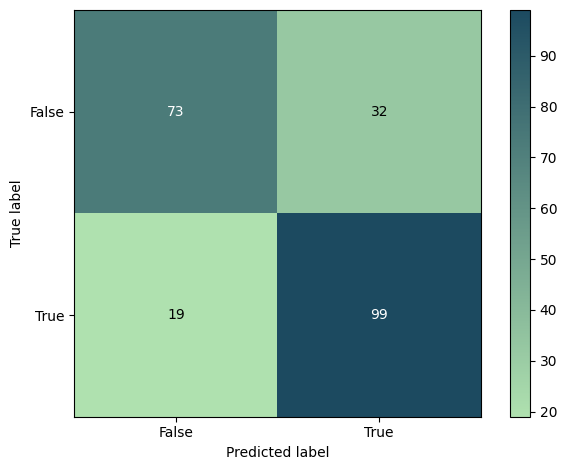

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 99
     - False Positive           : 32
     - True Negative            : 73
     - False Negative           : 19
     - True Positive Rate       :  0.8389830508474576
     - True Negative Rate       :  0.6952380952380952
     - Positive Predictive Value:  0.7557251908396947
     - Negative predictive value:  0.7934782608695652
     - False Positive Rate      :  0.3047619047619048
     - False Negative Rate      :  0.16101694915254236
     - False Discovery Rate     :  0.24427480916030533



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 128
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 9ms/ste

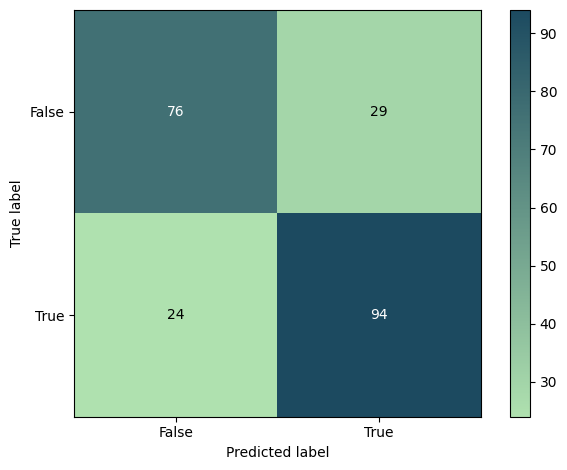

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 29
     - True Negative            : 76
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.7238095238095238
     - Positive Predictive Value:  0.7642276422764228
     - Negative predictive value:  0.76
     - False Positive Rate      :  0.2761904761904762
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.23577235772357724



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 32
Inner Dense Layer Size: 256
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 10ms/step
Accuracy: 0.

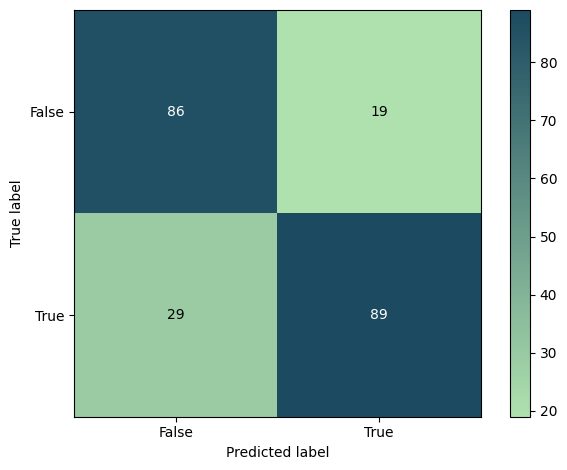

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 89
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 29
     - True Positive Rate       :  0.7542372881355932
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8240740740740741
     - Negative predictive value:  0.7478260869565218
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.2457627118644068
     - False Discovery Rate     :  0.17592592592592593



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 16
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 14ms/step

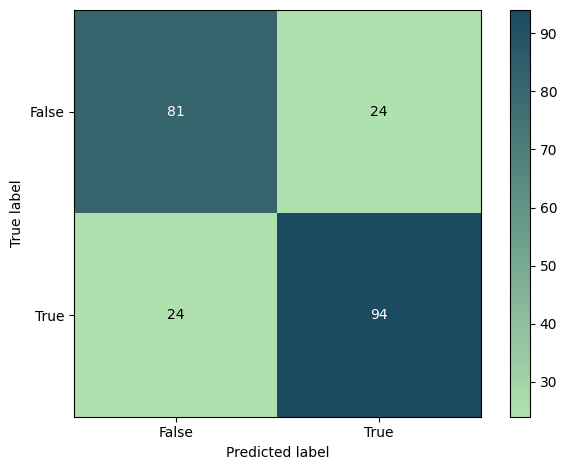

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 94
     - False Positive           : 24
     - True Negative            : 81
     - False Negative           : 24
     - True Positive Rate       :  0.7966101694915254
     - True Negative Rate       :  0.7714285714285715
     - Positive Predictive Value:  0.7966101694915254
     - Negative predictive value:  0.7714285714285715
     - False Positive Rate      :  0.22857142857142856
     - False Negative Rate      :  0.2033898305084746
     - False Discovery Rate     :  0.2033898305084746



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 32
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 15ms/step

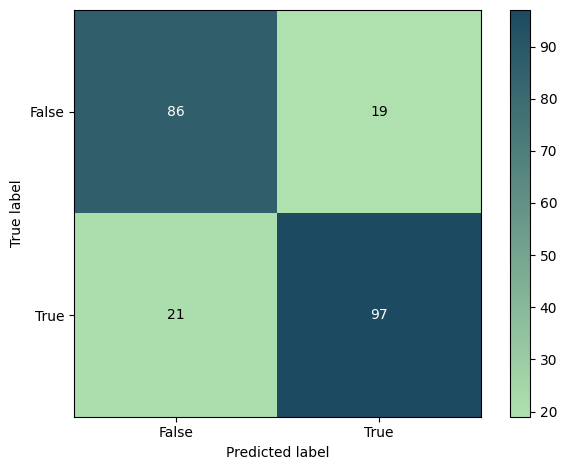

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8362068965517241
     - Negative predictive value:  0.8037383177570093
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.16379310344827586



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 64
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 14ms/ste

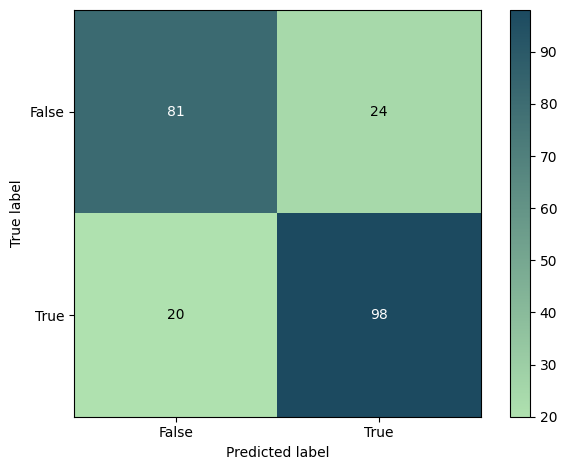

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 98
     - False Positive           : 24
     - True Negative            : 81
     - False Negative           : 20
     - True Positive Rate       :  0.8305084745762712
     - True Negative Rate       :  0.7714285714285715
     - Positive Predictive Value:  0.8032786885245902
     - Negative predictive value:  0.801980198019802
     - False Positive Rate      :  0.22857142857142856
     - False Negative Rate      :  0.1694915254237288
     - False Discovery Rate     :  0.19672131147540983



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 128
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 15ms/ste

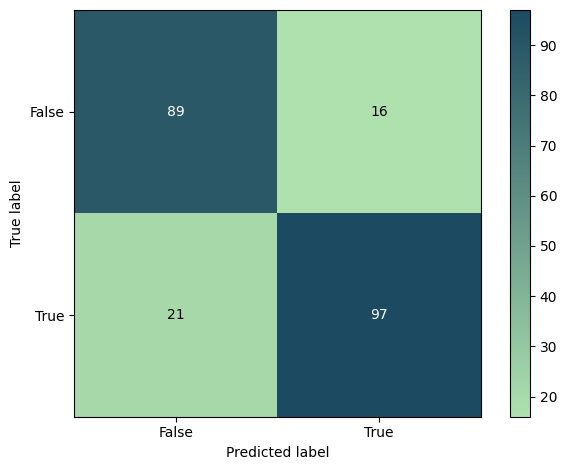

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8584070796460177
     - Negative predictive value:  0.8090909090909091
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.1415929203539823



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 64
Inner Dense Layer Size: 256
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 14ms/ste

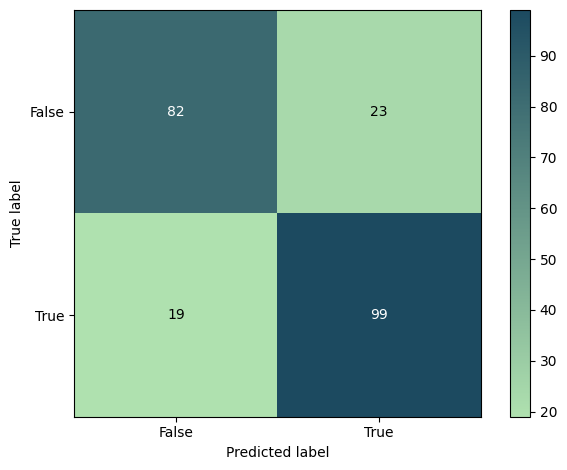

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 99
     - False Positive           : 23
     - True Negative            : 82
     - False Negative           : 19
     - True Positive Rate       :  0.8389830508474576
     - True Negative Rate       :  0.780952380952381
     - Positive Predictive Value:  0.8114754098360656
     - Negative predictive value:  0.8118811881188119
     - False Positive Rate      :  0.21904761904761905
     - False Negative Rate      :  0.16101694915254236
     - False Discovery Rate     :  0.1885245901639344



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 16
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 27ms/ste

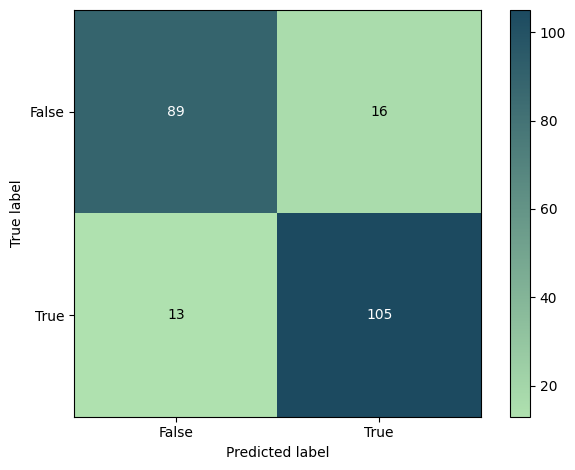

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 105
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 13
     - True Positive Rate       :  0.8898305084745762
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8677685950413223
     - Negative predictive value:  0.8725490196078431
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.11016949152542373
     - False Discovery Rate     :  0.1322314049586777



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 32
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 30ms/st

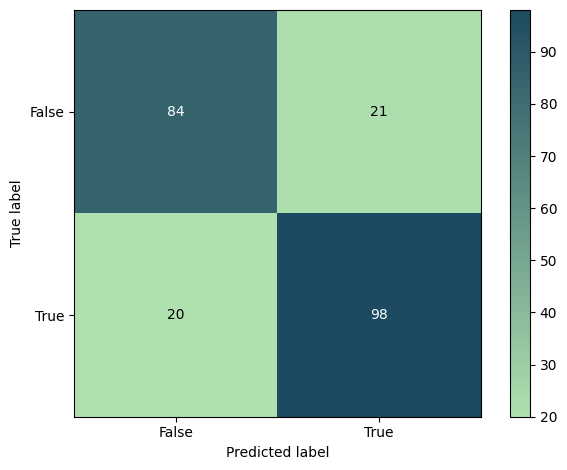

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 98
     - False Positive           : 21
     - True Negative            : 84
     - False Negative           : 20
     - True Positive Rate       :  0.8305084745762712
     - True Negative Rate       :  0.8
     - Positive Predictive Value:  0.8235294117647058
     - Negative predictive value:  0.8076923076923077
     - False Positive Rate      :  0.2
     - False Negative Rate      :  0.1694915254237288
     - False Discovery Rate     :  0.17647058823529413



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 64
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 29ms/step
Accuracy: 0.8251121076233184

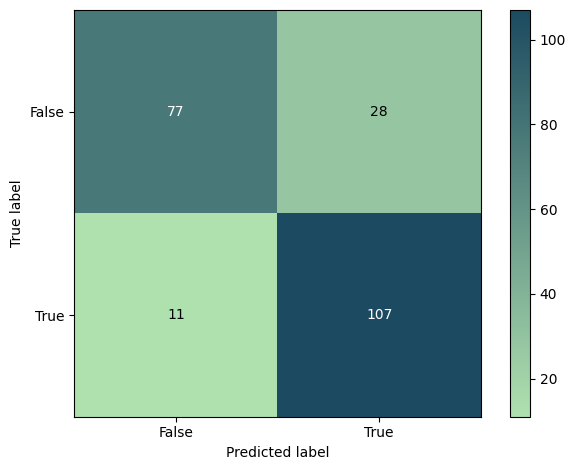

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 107
     - False Positive           : 28
     - True Negative            : 77
     - False Negative           : 11
     - True Positive Rate       :  0.9067796610169492
     - True Negative Rate       :  0.7333333333333333
     - Positive Predictive Value:  0.7925925925925926
     - Negative predictive value:  0.875
     - False Positive Rate      :  0.26666666666666666
     - False Negative Rate      :  0.09322033898305085
     - False Discovery Rate     :  0.2074074074074074



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 128
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 31ms/step
Accuracy

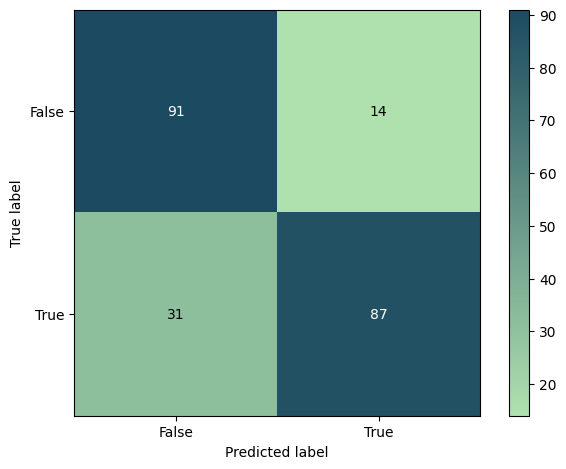

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 87
     - False Positive           : 14
     - True Negative            : 91
     - False Negative           : 31
     - True Positive Rate       :  0.7372881355932204
     - True Negative Rate       :  0.8666666666666667
     - Positive Predictive Value:  0.8613861386138614
     - Negative predictive value:  0.7459016393442623
     - False Positive Rate      :  0.13333333333333333
     - False Negative Rate      :  0.2627118644067797
     - False Discovery Rate     :  0.13861386138613863



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 128
Inner Dense Layer Size: 256
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 0s 30ms/s

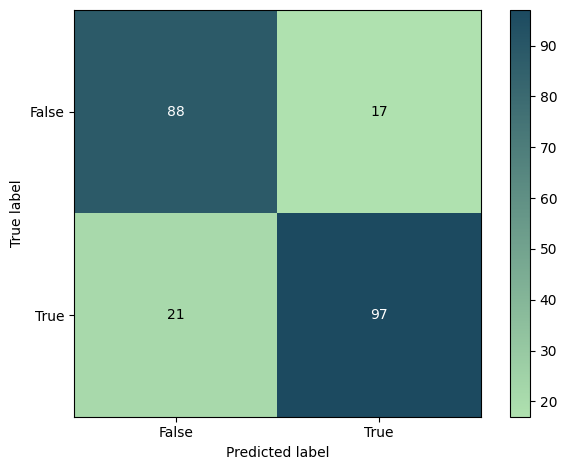

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 97
     - False Positive           : 17
     - True Negative            : 88
     - False Negative           : 21
     - True Positive Rate       :  0.8220338983050848
     - True Negative Rate       :  0.8380952380952381
     - Positive Predictive Value:  0.8508771929824561
     - Negative predictive value:  0.8073394495412844
     - False Positive Rate      :  0.1619047619047619
     - False Negative Rate      :  0.17796610169491525
     - False Discovery Rate     :  0.14912280701754385



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 16
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 87ms/st

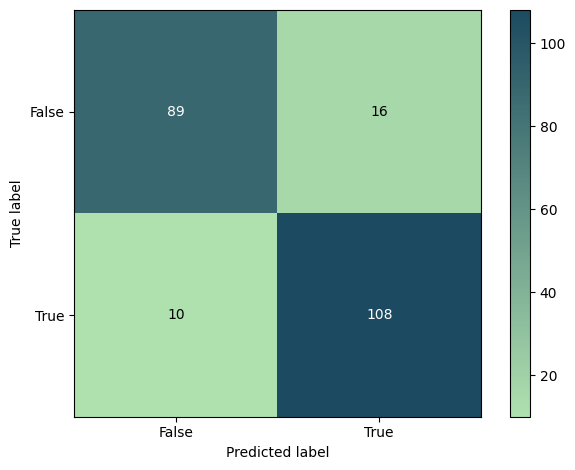

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 108
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 10
     - True Positive Rate       :  0.9152542372881356
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8709677419354839
     - Negative predictive value:  0.898989898989899
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.0847457627118644
     - False Discovery Rate     :  0.12903225806451613



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 32
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 82ms/ste

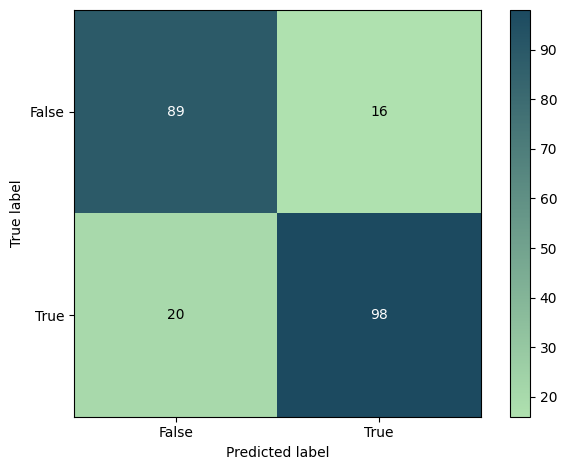

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 98
     - False Positive           : 16
     - True Negative            : 89
     - False Negative           : 20
     - True Positive Rate       :  0.8305084745762712
     - True Negative Rate       :  0.8476190476190476
     - Positive Predictive Value:  0.8596491228070176
     - Negative predictive value:  0.8165137614678899
     - False Positive Rate      :  0.1523809523809524
     - False Negative Rate      :  0.1694915254237288
     - False Discovery Rate     :  0.14035087719298245



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 64
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 86ms/ste

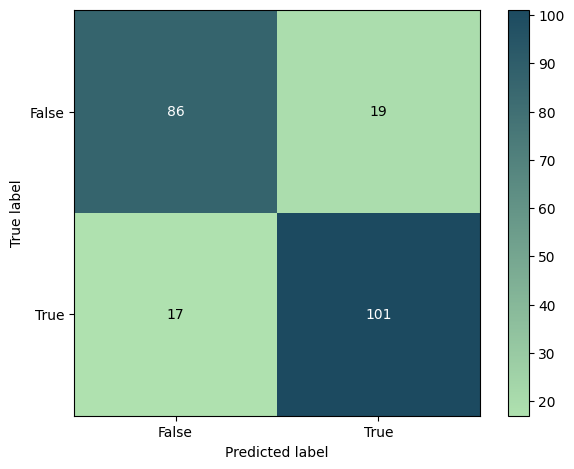

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 101
     - False Positive           : 19
     - True Negative            : 86
     - False Negative           : 17
     - True Positive Rate       :  0.8559322033898306
     - True Negative Rate       :  0.819047619047619
     - Positive Predictive Value:  0.8416666666666667
     - Negative predictive value:  0.8349514563106796
     - False Positive Rate      :  0.18095238095238095
     - False Negative Rate      :  0.1440677966101695
     - False Discovery Rate     :  0.15833333333333333



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 128
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 82ms/s

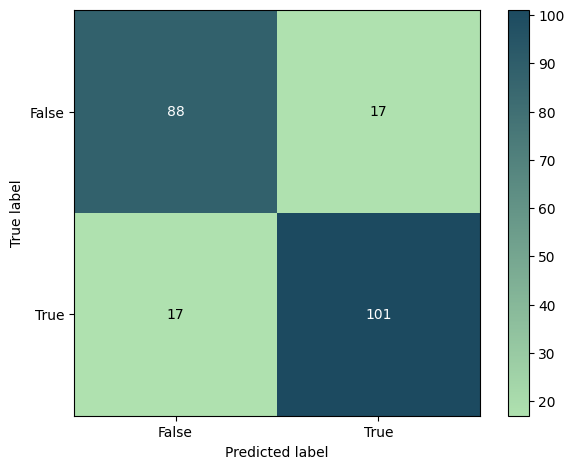

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 101
     - False Positive           : 17
     - True Negative            : 88
     - False Negative           : 17
     - True Positive Rate       :  0.8559322033898306
     - True Negative Rate       :  0.8380952380952381
     - Positive Predictive Value:  0.8559322033898306
     - Negative predictive value:  0.8380952380952381
     - False Positive Rate      :  0.1619047619047619
     - False Negative Rate      :  0.1440677966101695
     - False Discovery Rate     :  0.1440677966101695



##########################################
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LSTM Layer Size       : 256
Inner Dense Layer Size: 256
Epoch Num             : 100
data_dir updated to: ../../../data/audio_features/MFCC_audio_features

Selected csv_path: ../../../data/data_split_paths_CSVs/
(520, 130, 20) (520,) (223, 130, 20) (223,)
7/7 [==============================] - 1s 91ms/st

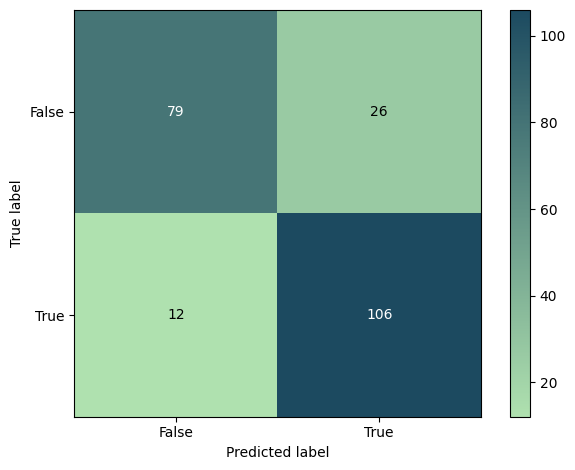

---------------------------------------------------------------

Metrics Rates:
     - True Positive            : 106
     - False Positive           : 26
     - True Negative            : 79
     - False Negative           : 12
     - True Positive Rate       :  0.8983050847457628
     - True Negative Rate       :  0.7523809523809524
     - Positive Predictive Value:  0.803030303030303
     - Negative predictive value:  0.8681318681318682
     - False Positive Rate      :  0.24761904761904763
     - False Negative Rate      :  0.1016949152542373
     - False Discovery Rate     :  0.19696969696969696



##########################################


In [3]:
LSTM_grid_search_Audio(csv_path="../../../data/data_split_paths_CSVs/",
                       data_dir="../../../data/audio_features/",
                       feature_type="MFCC",
                       lstm_feat_size_lst=[16, 32, 64, 128, 256],
                       inner_dense_layer_size_lst=[16, 32, 64, 128, 256],
                       epoch_num=100,
                       batch_size=32,
                       verbose=False)